In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import random 
from PIL import Image 
import matplotlib.patches as patches
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams["figure.dpi"] = 150

In [2]:
image_dir = '../data_lacmus/TrainingData/JPEGImages'
split_dir = '../data_lacmus/TrainingData/ImageSets/Main'
xml_dir = '../data_lacmus/TrainingData/Annotations'

In [3]:
splits = ['train', 'train_non_empty', 'trainval', 'val', 'test', 'valtest']

In [4]:
split2filenames = {}
for split in splits:
    with open(f'{split_dir}/{split}.txt', 'r') as f:
        for line in f:
            if split in split2filenames:
                split2filenames[split].append(line.strip())
            else:
                split2filenames[split] = [line.strip()]

In [5]:
for s in split2filenames:
    print(f'{s} : {len(split2filenames[s])}')

train : 1020
train_non_empty : 987
trainval : 1220
val : 200
test : 200
valtest : 400


In [6]:
#with open(f'{split_dir}/valtest.txt', 'w') as f:
#    for s in ['val', 'test']:
#        for filename in split2filenames[s]:
#            f.write(f'{filename}\n')

In [7]:
import xml.etree.ElementTree as ET
import collections

def parse_voc_xml(node):
    voc_dict = {}
    children = list(node)
    if children:
        def_dic = collections.defaultdict(list)
        for dc in map(parse_voc_xml, children):
            for ind, v in dc.items():
                def_dic[ind].append(v)
        if node.tag == 'annotation':
            def_dic['object'] = [def_dic['object']]
        voc_dict = {
            node.tag:
                {ind: v[0] if len(v) == 1 else v
                 for ind, v in def_dic.items()}
        }
    if node.text:
        text = node.text.strip()
        if not children:
            voc_dict[node.tag] = text
    return voc_dict

def read_xml(xml_filename):
    description = parse_voc_xml(ET.parse(xml_filename).getroot())

    # get bounding box coordinates 
    num_objs = len(description['annotation']['object'])
    boxes = []
    for l in description['annotation']['object']:
        bb = l['bndbox']
        boxes.append([int(bb['xmin']), 
                      int(bb['ymin']), 
                      int(bb['xmax'])-int(bb['xmin']), 
                      int(bb['ymax'])-int(bb['ymin'])])
        
    return boxes

In [8]:
def show_image(split):
    filenames = split2filenames[split]
    filename = filenames[random.randint(0, len(filenames))]
    print(filename)
    
    im = Image.open(f'{image_dir}/{filename}.jpg').convert('RGB')
    fig, ax = plt.subplots()    
    ax.imshow(im)
    
    xml_filename = f'{xml_dir}/{filename}.xml'
    if os.path.exists(xml_filename):
        boxes = read_xml(xml_filename)
        for box in boxes:
            x = box[0]
            y = box[1]
            w = box[2]
            h = box[3]      
            rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

    plt.show()

869


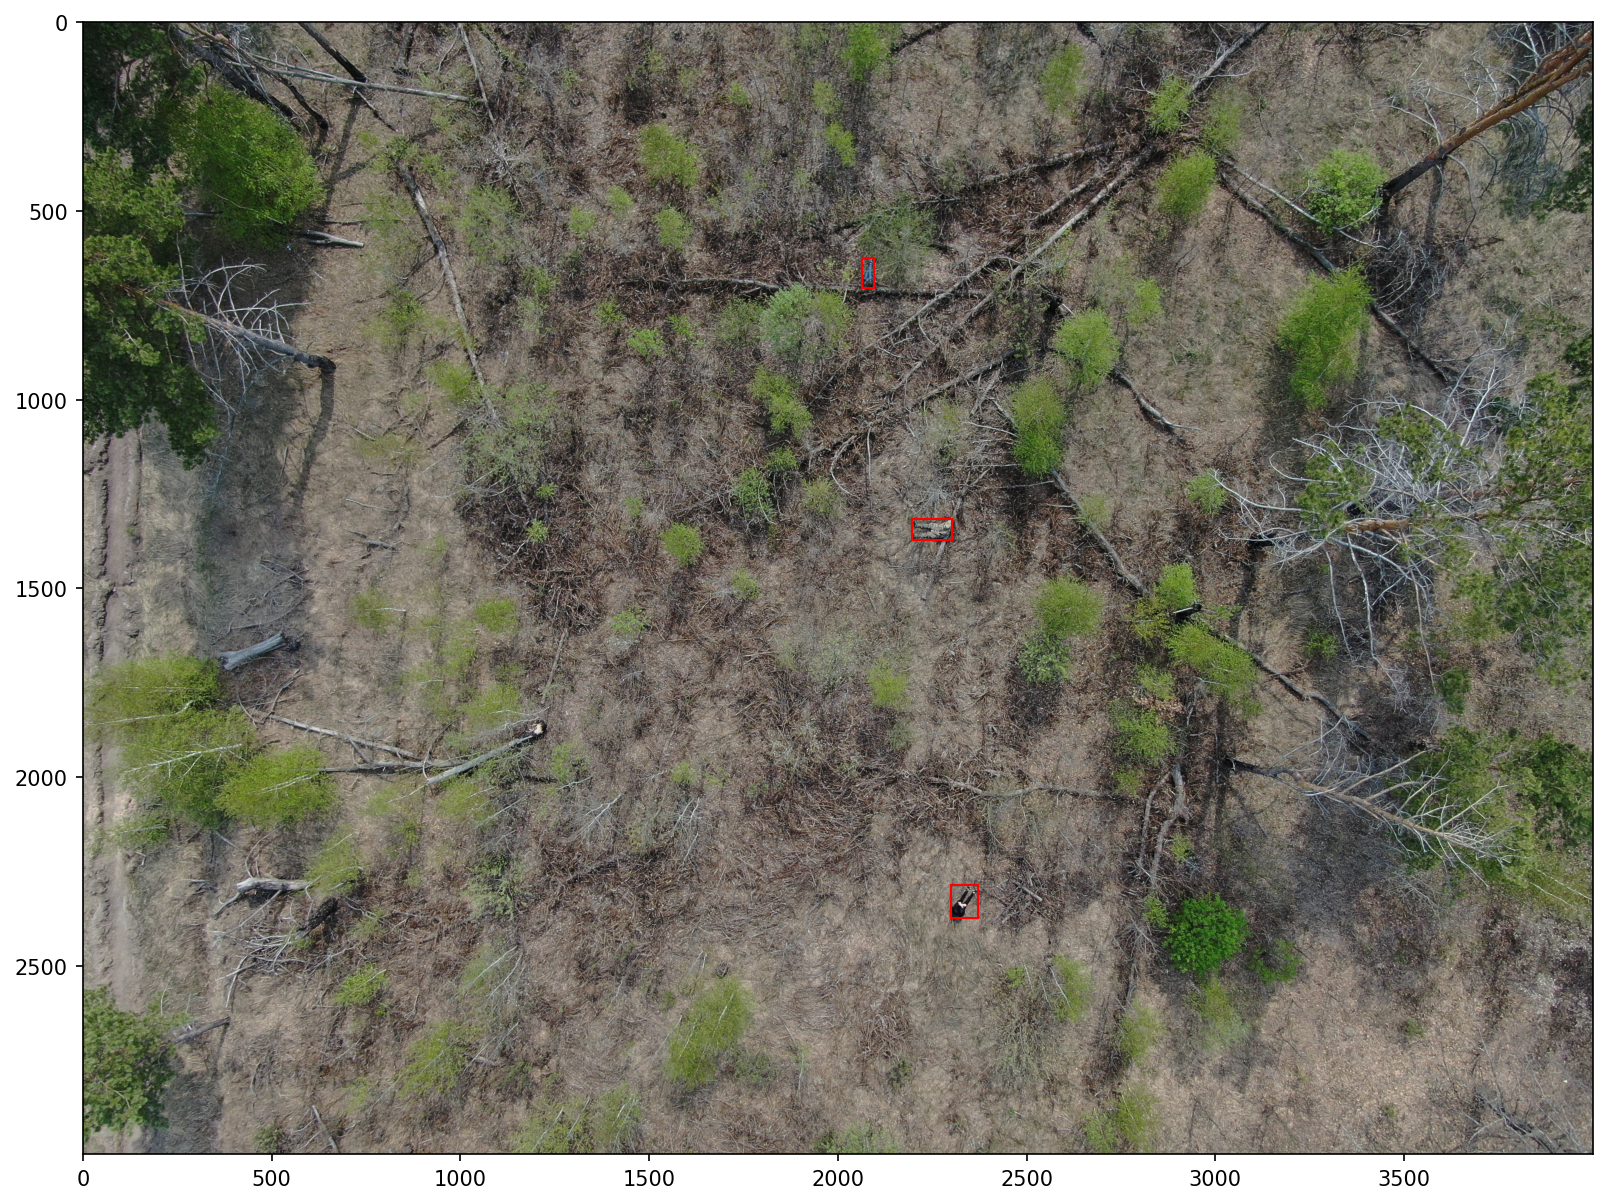

In [9]:
split = 'train'
show_image(split)

In [10]:
def stat_size(split):
    filenames = split2filenames[split]
    Ws = []
    Hs = []
    for filename in tqdm(filenames):
        im = Image.open(f'{image_dir}/{filename}.jpg').convert('RGB')
        w, h = im.size
        Ws.append(w)
        Hs.append(h)
    stats = {f'{split}_w': Ws, 
             f'{split}_h': Hs}
    return pd.DataFrame(stats)

In [11]:
df = dict()
for split in splits:
    df[split] = stat_size(split)

100%|█████████████████████████████████████████| 400/400 [01:21<00:00,  4.93it/s]


In [13]:
splits = ['train', 'train_non_empty', 'trainval', 'val', 'test', 'valtest']

In [14]:
df['train'].describe()

train_w      train_h
count  1020.000000  1020.000000
mean   4340.054902  3010.868627
std     553.224394   369.566569
min    4000.000000  2250.000000
25%    4000.000000  3000.000000
50%    4000.000000  3000.000000
75%    4864.000000  3078.000000
max    5472.000000  3648.000000

In [15]:
df['train_non_empty'].describe()

train_non_empty_w  train_non_empty_h
count         987.000000         987.000000
mean         4351.424519        3034.788247
std           558.838894         349.823135
min          4000.000000        2250.000000
25%          4000.000000        3000.000000
50%          4000.000000        3000.000000
75%          4864.000000        3078.000000
max          5472.000000        3648.000000

In [16]:
df['valtest'].describe()

valtest_w    valtest_h
count   400.000000   400.000000
mean   4360.400000  2976.600000
std     567.742961   405.792198
min    4000.000000  2250.000000
25%    4000.000000  3000.000000
50%    4000.000000  3000.000000
75%    4864.000000  3078.000000
max    5472.000000  3648.000000